In [ ]:
# set main directory name
dir = dirname(pwd());

# Second model
In this notebook I build the second toy model. The idea is now to observe death time exactly and don't bound the metastasis number.

In [1]:
using DataFrames
using DifferentialEquations
using JumpProcesses
using Plots
# using PlotlyJS
using Statistics
using Distributions
using Random
using JLD2

using Optimization
using OptimizationOptimJL

using CSV
using DataFrames
using DelimitedFiles
using Measures
# include own module with functionalities
# include("functionalities.jl")
using MyFunctionalities

# set seed for reproducibility
Random.seed!(123);

## Ode-Model
The model consists of an ODE and two Markov jump processes parameterized with 6 rate parameters.

In [2]:
# define the drift function
function TumorODE!(du, u, p, t)
    if (u[3] == 0)
        du[1] = p.beta*u[1]
    else
        du[1] = 0
    end
end

# define the jump-rate functions
metastasis_rate(u, p, t) = p.m_basal+p.m_size*sqrt(u[1])
death_rate(u, p, t) = p.d_basal+p.d_size*sqrt(u[1])+p.d_metastasis*u[2]

# define the jump functions
function metastasis_affect!(integrator)
    if (integrator.u[3] == 0) 
        integrator.u[2] += 1
    end
    nothing
end

function death_affect!(integrator)
    if (integrator.u[3] == 0) 
        integrator.u[3] += 1
    end
    # terminate!(integrator) # could stop the simulation after death, but for visualization reasons one might not want to.
    nothing
end

death_affect! (generic function with 1 method)

## Full model simulation

In [3]:
# set model parameter values
beta = 0.3
m_basal = 0.05
m_size = 0.1
d_basal = 0.005
d_size = 0.005
d_metastasis = 0.01


p = (beta = beta, m_basal = m_basal, m_size = m_size, d_basal = d_basal, d_size = d_size, d_metastasis = d_metastasis)

# set initial condition 
S0 = 0.05
u0 = [S0, 0, 0]

# set time interval
endtime = 30.0
tspan = (0.0, endtime)

# set chosen observation noise
sigma = 0.1;

In [4]:

# define the ODE problem
prob = ODEProblem(TumorODE!, u0, tspan, p)

# define the jump problem
metastasis_jump = VariableRateJump(metastasis_rate, metastasis_affect!)
death_jump =  VariableRateJump(death_rate, death_affect!)
jump_problem = JumpProblem(prob, Direct(), metastasis_jump, death_jump)

# solve the problem
full_sol = solve(jump_problem, Tsit5(), tstops=0.0:1.0:30.0);



In [5]:
death_idx = findfirst(full_sol[3,:].>0)
death_time = full_sol.t[death_idx]
interobs_time = death_time/4

6.191287814166251

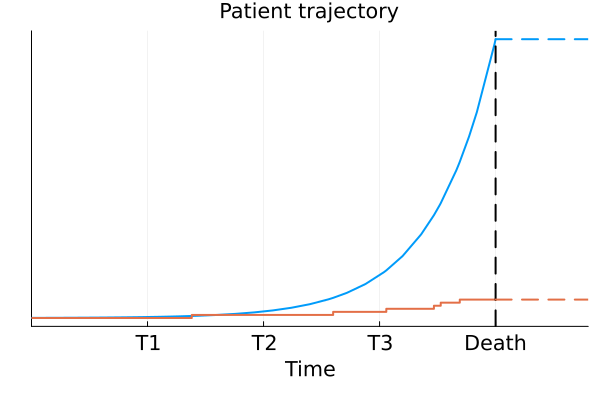

In [37]:
# plot the problem
plt = plot(full_sol[1:death_idx],
           idxs =[1,2],
           xlimit=(0, endtime), 
           title="Patient trajectory", 
           titlefontsize=14,
           xlabel="Time", 
           xguidefontsize=14,
           yguidefontsize=14, 
           xticks=(interobs_time:interobs_time:death_time, ["T1", "T2", "T3", "Death"]), 
           yticks=false,
           tickfontsize = 14,
           legend=false, 
           linewidth=2,
           size=(600,400),
           left_margin=6mm,
           bottom_margin=6mm,)

vline!(plt, [full_sol.t[death_idx]], linewidth=2, color="black", linestyle=:dash, label="Death time")
plot!(plt, [death_time, endtime], [full_sol(death_time)[2], full_sol(death_time)[2]], linewidth=2, linecolor="#e26f46", linestyle=:dash)
plot!(plt, [death_time, endtime], [full_sol(death_time)[1], full_sol(death_time)[1]], linewidth=2, linecolor="#009af9", linestyle=:dash)


In [38]:
# save plot
savefig(plt, "figures/patient_trajectory.png")

"/home/vincent/PhD/Projects/method_project/second_model/figures/patient_trajectory.png"

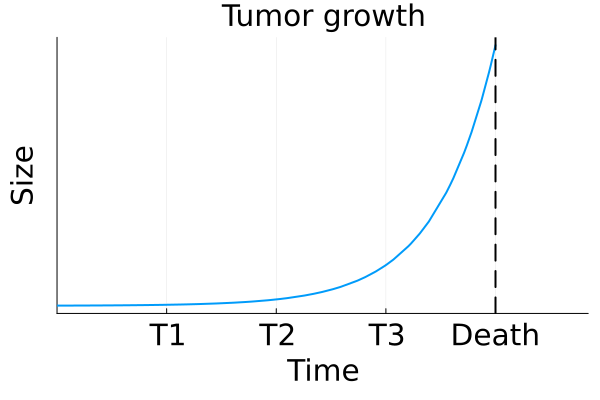

In [17]:
plt = plot(full_sol[1:death_idx], 
           idxs=(1), 
           xlimit=(0, endtime), 
           title="Tumor growth", 
           titlefontsize=20,
           xlabel="Time", 
           ylabel="Size",
           xguidefontsize=20,
           yguidefontsize=20, 
           xticks=(interobs_time:interobs_time:death_time, ["T1", "T2", "T3", "Death"]), 
           tickfontsize = 20,
           yticks=false, 
           legend=false, 
           linewidth=2,
           size=(600,400),
           left_margin=6mm,
           bottom_margin=6mm)

vline!(plt, [full_sol.t[death_idx]], linewidth=2, color="black", linestyle=:dash, label="Death time")


In [18]:
# save plot
savefig(plt, "figures/ode_growth.svg")

"/home/vincent/PhD/Projects/method_project/second_model/figures/ode_growth.svg"

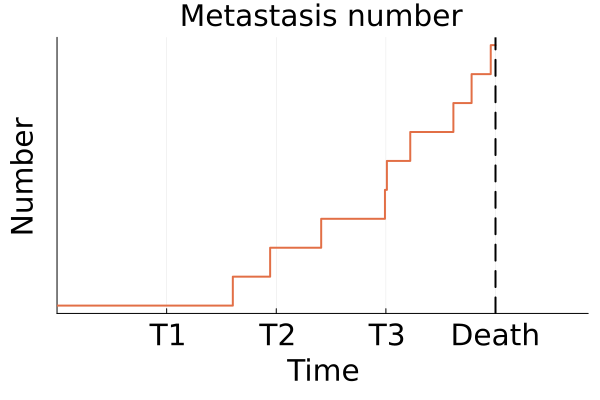

In [15]:
plt = plot(full_sol[1:death_idx], 
           idxs=(2), 
           xlimit=(0, endtime), 
           title="Metastasis number", 
           titlefontsize=20,
           xlabel="Time", 
           ylabel="Number",
           xguidefontsize=20,
           yguidefontsize=20, 
           xticks=(interobs_time:interobs_time:death_time, ["T1", "T2", "T3", "Death"]), 
           tickfontsize = 20,
           yticks=false, 
           legend=false, 
           linewidth=2,
           linecolor="#e26f46",
           size=(600,400),
           left_margin=6mm,
           bottom_margin=6mm)

vline!(plt, [full_sol.t[death_idx]], linewidth=2, color="black", linestyle=:dash, label="Death time")
# plot!(plt, [death_time, endtime], [full_sol(death_time)[2], full_sol(death_time)[2]], linewidth=2, linecolor="#e26f46", linestyle=:dash)

In [16]:
# save plot
savefig(plt, "figures/metastasis_number.svg")

"/home/vincent/PhD/Projects/method_project/second_model/figures/metastasis_number.svg"

In [ ]:
# plot the three subprocesses in subfigures
plt1 = plot(full_sol, vars=(1), xlimit=(0, endtime), color="blue", linewidth=2, figsize=(12,8))
plt2 = plot(full_sol, vars=(2), xlimit=(0, endtime), color="orange", linewidth=2, figsize=(12,8))
plt3 = plot(full_sol, vars=(3), xlimit=(0, endtime), color="black", linewidth=2, figsize=(12,8))
plt = plot(plt1, plt2, plt3, layout=(3,1), title="Cancer processes", xlabel="Time", legend=false, size=(600,1200))


In [71]:
# save plot as pdf
savefig("tumor_model.pdf")

"/home/vincent/PhD/Projects/method_project/second_model/tumor_model.pdf"

In [20]:
# solve the problem
s1 = solve(jump_problem, Tsit5(), tstops=0.0:1.0:30.0);
s2 = solve(jump_problem, Tsit5(), tstops=0.0:1.0:30.0);

In [ ]:
# solve the problem
full_sol = solve(jump_problem, Tsit5(), tstops=0.0:1.0:30.0)
timepoints = 0.0:1.0:30.0
timepoints = timepoints[timepoints .< full_sol.t[end]]
push!(timepoints, full_sol.t[end])

# time_indices = findall(full_sol.t .== timepoints)
u = full_sol(timepoints, continuity = :right)
u = [u[i][1:3] for i in 1:length(u)]
timepoints

In [21]:
u1, u2 = s1.u, s2.u

(ExtendedJumpArray{Float64, 1, Vector{Float64}, Vector{Float64}}[[0.05, 0.0, 0.0], [0.05228578856436935, 0.0, 0.0], [0.06490131312893974, 0.0, 0.0], [0.06749294037466662, 0.0, 0.0], [0.08304269222867927, 0.0, 0.0], [0.09110594002168, 0.0, 0.0], [0.1194644224598829, 0.0, 0.0], [0.12298015510295539, 0.0, 0.0], [0.15004156317878084, 0.0, 0.0], [0.1660058455505376, 0.0, 0.0]  …  [29.681367759740176, 6.0, 0.0], [29.681367759740176, 7.0, 0.0], [36.75475821367942, 7.0, 0.0], [41.97696606202834, 7.0, 0.0], [41.97696606202834, 8.0, 0.0], [42.3402774239629, 8.0, 0.0], [42.3402774239629, 9.0, 0.0], [49.61373454557302, 9.0, 0.0], [60.1508938050017, 9.0, 0.0], [60.1508938050017, 9.0, 1.0]], ExtendedJumpArray{Float64, 1, Vector{Float64}, Vector{Float64}}[[0.05, 0.0, 0.0], [0.051819454158066235, 0.0, 0.0], [0.06287425464914528, 0.0, 0.0], [0.067492940390692, 0.0, 0.0], [0.06939145752687205, 0.0, 0.0], [0.06939145752687205, 1.0, 0.0], [0.08557119511455505, 1.0, 0.0], [0.09110594164150407, 1.0, 0.0], [

Remember that solutions are stored left continuous for interpolation!

## Create simulated data

In [5]:
using DifferentialEquations.EnsembleAnalysis

In [7]:
# Lets define an ensemble of several patients
npat = 200
ensembleprob = EnsembleProblem(jump_problem)
ensemble_sol = solve(ensembleprob, Tsit5(), EnsembleThreads(); trajectories = npat, tstops=0.0:1.0:endtime)

EnsembleSolution Solution of length 200 with uType:
ODESolution{Float64, 2, Vector{ExtendedJumpArray{Float64, 1, Vector{Float64}, Vector{Float64}}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{ExtendedJumpArray{Float64, 1, Vector{Float64}, Vector{Float64}}}}, ODEProblem{ExtendedJumpArray{Float64, 1, Vector{Float64}, Vector{Float64}}, Tuple{Float64, Float64}, true, @NamedTuple{beta::Float64, m_basal::Float64, m_size::Float64, d_basal::Float64, d_size::Float64, d_metastasis::Float64}, ODEFunction{true, SciMLBase.FullSpecialize, JumpProcesses.var"#135#138"{Tuple{VariableRateJump{typeof(metastasis_rate), typeof(metastasis_affect!), Nothing, Nothing, Nothing, Nothing, Float64, Int64}, VariableRateJump{typeof(death_rate), typeof(death_affect!), Nothing, Nothing, Nothing, Nothing, Float64, Int64}}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(TumorODE!), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [7]:
tp = 0:0.1:30
mean_traj = timeseries_point_mean(ensemble_sol, tp);
low_quantile = timeseries_point_quantile(ensemble_sol, 0.05, tp);
high_quantile = timeseries_point_quantile(ensemble_sol, 0.95, tp);

mean_sde = [mean_traj.u[i][1] for i in 1:length(tp)]
mean_m = [mean_traj.u[i][2] for i in 1:length(tp)]
mean_d = [mean_traj.u[i][3] for i in 1:length(tp)]

low_sde = [low_quantile.u[i][1] for i in 1:length(tp)]
low_m = [low_quantile.u[i][2] for i in 1:length(tp)]
low_d = [low_quantile.u[i][3] for i in 1:length(tp)]

high_sde = [high_quantile.u[i][1] for i in 1:length(tp)]
high_m = [high_quantile.u[i][2] for i in 1:length(tp)]
high_d = [high_quantile.u[i][3] for i in 1:length(tp)];


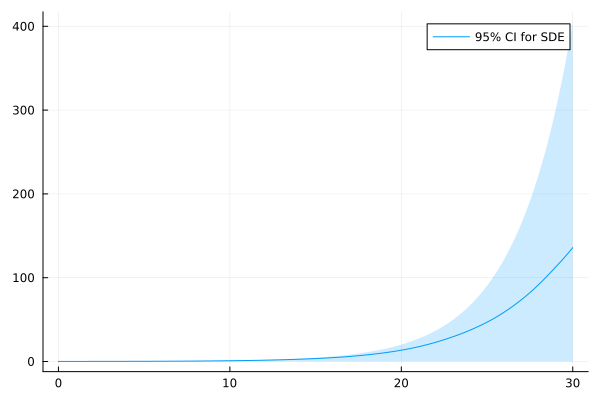

In [8]:
plot(tp, mean_sde, ribbon=((mean_sde-low_sde),high_sde-mean_sde), fillalpha=0.2, label="95% CI for SDE")

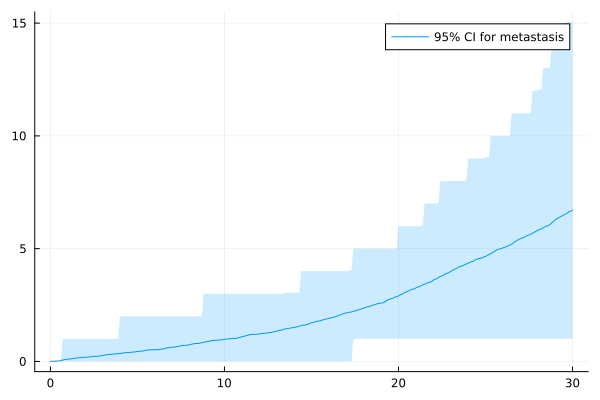

In [9]:
plot(tp, mean_m, ribbon=((mean_m-low_m),high_m-mean_m), fillalpha=0.2, label="95% CI for metastasis")

In [8]:
patient_data = DataFrame(patient_id=Int64[], time=Real[], tumor=Real[], metastasis=Real[], death=Real[])
timepoints = 0:1:30

for i in 1:npat
    single_sol = ensemble_sol[i]
    death_values = Int.([single_sol.u[i][3] for i in 1:length(single_sol.u)])
    death_index = findfirst(death_values .== 1)
    if (death_index != nothing) 
        new_timepoints = timepoints[findall(timepoints .< single_sol.t[death_index])] # get all observation times before death
        patient_data = vcat(
        patient_data, 
        DataFrame(
            patient_id=i, 
            time=new_timepoints, 
            tumor=rand(MvNormal(hcat(ensemble_sol[i](new_timepoints).u...)[1, :], sigma.*hcat(ensemble_sol[i](new_timepoints).u...)[1, :])), 
            metastasis = Int.(hcat(ensemble_sol[i](new_timepoints).u...)[2, :]),
            death=Int.(hcat(ensemble_sol[i](new_timepoints).u...)[3, :])
        )
        )
        # add death observation withe exact death time
        death_timepoint = [single_sol.t[death_index]]
        patient_data = vcat(
        patient_data, 
        DataFrame(
            patient_id=i, 
            time=death_timepoint, 
            tumor=rand(Normal(single_sol.u[death_index][1], sigma*single_sol.u[death_index][1])), 
            metastasis = Int.(single_sol.u[death_index][2]),
            death=Int.(single_sol.u[death_index][3])
        )
        )
    else
        patient_data = vcat(
            patient_data, 
            DataFrame(
                patient_id=i, 
                time=timepoints, 
                tumor=rand(MvNormal(hcat(ensemble_sol[i](timepoints).u...)[1, :], sigma.*hcat(ensemble_sol[i](timepoints).u...)[1, :])),  
                metastasis = Int.(hcat(ensemble_sol[i](timepoints).u...)[2, :]),
                death=Int.(hcat(ensemble_sol[i](timepoints).u...)[3, :])
            )
        )
    end
end
# store underlying parameters in first entry
θ = [beta, m_basal, m_size, d_basal, d_size, d_metastasis]
parameters = [θ..., fill(missing, length(patient_data.patient_id)-length(θ))...]
patient_data[!, :parameters] = parameters;

In [11]:
# data_path = joinpath(dirname(pwd()), "data/second_model/ODE_$(npat)_test_patients_noisy.csv")

# CSV.write(data_path, patient_data)

## Alternative data creation
Based on  a one-step Euler approximation

In [12]:
rng = MersenneTwister(123)

function growth(t, S0, beta)
    return S0 * exp(beta * t)
end

function sample_single(patient_id_, beta_, m_basal_, m_size_, d_basal_, d_size_, d_metas_, S0_, timepoints_)
    TIME_STEP = 0.001

    t_end = timepoints_[end]
    times = [Float64(timepoints_[1])]
    tumour_sizes = [S0_ + 0.1 * S0_ * randn(rng)]
    metastases = [0]
    death_status = [0]
    DEAD_FLAG = false

    for time in (0.0 + TIME_STEP):TIME_STEP:t_end
        push!(times, time)
        

        if TIME_STEP * (d_basal_ + d_size_ * sqrt(tumour_sizes[end]) + d_metas_ * metastases[end]) > rand(rng) || DEAD_FLAG
            push!(death_status, 1)
            DEAD_FLAG = true
        else
            push!(death_status, 0)
        end

        if (TIME_STEP * (m_basal_ + m_size_ * sqrt(tumour_sizes[end])) > rand(rng)) && (metastases[end] < 4)
            push!(metastases, metastases[end] + 1)
        else
            push!(metastases, metastases[end])
        end

        push!(tumour_sizes, growth(time, S0_, beta_) + 0.1 * S0_ * randn(rng))
    end

    # Subset to those values of times which are elements of timepoints_


    sub_idc = findall(x -> x in timepoints_, times)

    times = times[sub_idc]
    tumour_sizes = tumour_sizes[sub_idc]
    metastases = metastases[sub_idc]
    death_status = death_status[sub_idc]

    return_df = DataFrame(
        patient_id = repeat([patient_id_], length(sub_idc)),
        time = times,
        tumor = tumour_sizes,
        metastasis = metastases,
        death = death_status
    )    

    dead_idc = findall(x -> x == 1, return_df.death)

    if length(dead_idc) > 0
        return_df = return_df[1:dead_idc[1], :]
    end
    return return_df
end

function sample_many(npat_, beta_, m_basal_, m_size_, d_basal_, d_size_, d_metas_, S0_, timepoints_)
    df = DataFrame()
    for i in 1:npat_
        df = vcat(df, sample_single(i, beta_, m_basal_, m_size_, d_basal_, d_size_, d_metas_, S0_, timepoints_))
    end

    
    return df
end

sample_many (generic function with 1 method)

In [13]:
alternative_data = sample_many(npat, beta, m_basal, m_size, d_basal, d_size, d_metastasis, S0, timepoints);

# store underlying parameters in first entry
θ = [beta, m_basal, m_size, d_basal, d_size, d_metastasis]
parameters = [θ..., fill(missing, length(alternative_data.patient_id)-length(θ))...]
alternative_data[!, :parameters] = parameters;

In [14]:
# alternative_data_path = joinpath(dirname(pwd()), "data/second_model/ODE_$(npat)_alternative_test_patients_noisy.csv");

# CSV.write(alternative_data_path, alternative_data)

## Data visualization

47 patients survived.


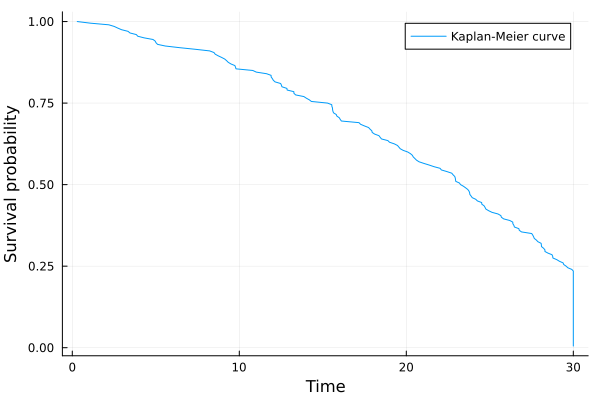

In [9]:
# Get death lines per patient from patient_data

death_lines = Vector{Any}(undef, npat)
nalive = 0

for i in 1:npat
    try
        death_index = findfirst(patient_data[patient_data.patient_id .== i, :].death .== 1)

        death_lines[i] = patient_data[patient_data.patient_id .== i, :][death_index, :]
    catch e
        nalive += 1
        death_lines[i] = patient_data[patient_data.patient_id .== i, :][end, :]
    end
end

# Plot histogram of metastasis numbers per line in death lines

metastasis_numbers = zeros(npat)
for i in 1:npat
    metastasis_numbers[i] = death_lines[i].metastasis[1]
end

survivals = Vector{Any}(undef, npat)

for i in 1:npat
    survivals[i] = death_lines[i].time[1]
end

# Plot Kaplan-Meier curve for survivals

# sort by survival
sorted_survivals = sort(survivals)

# get survival probabilities
survival_probs = zeros(npat) 

for i in 1:npat
    survival_probs[i] = (npat - i + 1) / npat
end

# plot
println("$nalive patients survived.")
plot(sorted_survivals, survival_probs, xlabel="Time", ylabel="Survival probability", label="Kaplan-Meier curve")

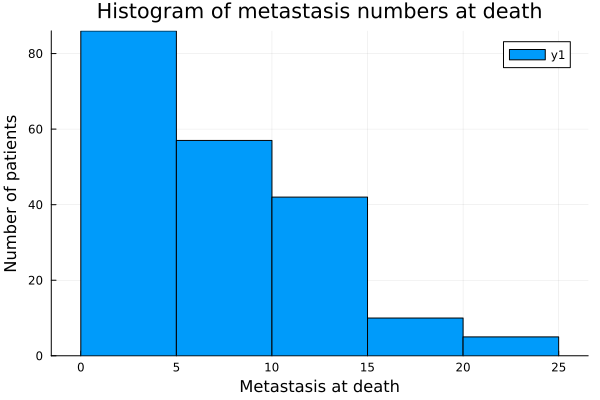

In [16]:
# Histogram of metastasis numbers at death

histogram(metastasis_numbers, bins=5, xlabel="Metastasis at death", ylabel="Number of patients", title="Histogram of metastasis numbers at death")

In the alternative simulation less patients tend to survive or sometimes more. In general that number seems to vary quiet a lot.

## Likelihood-based Optimization 
The likelihood was calculated by solving it analytically in Mathematica for all observed cases.

In [3]:
include("constr_met_likelihoods.jl");

In [4]:
# load different dataset with corresponding underlying parameters
npat = 200
data_path1 = joinpath(dirname(pwd()), "data/second_model/ODE_$(npat)_test_patients_noisy.csv")
patient_data1 = CSV.read(data_path1, DataFrame);
beta, m_basal, m_size, d_basal, d_size, d_metas = patient_data1.parameters
p1 = (beta = beta, m_basal = m_basal, m_size = m_size, d_basal = d_basal, d_size = d_size, d_metas = d_metas)

# laod data
npat = 200
data_path2 = joinpath(dirname(pwd()), "data/second_model/ODE_$(npat)_test2_patients_noisy.csv")
patient_data2 = CSV.read(data_path2, DataFrame);
beta, m_basal, m_size, d_basal, d_size, d_metas = patient_data2.parameters
p2 = (beta = beta, m_basal = m_basal, m_size = m_size, d_basal = d_basal, d_size = d_size, d_metas = d_metas)

npat = 200
data_path = joinpath(dirname(pwd()), "data/second_model/ODE_$(npat)_alternative_test_patients_noisy.csv")
alternative_data = CSV.read(data_path, DataFrame);
beta, m_basal, m_size, d_basal, d_size, d_metas = alternative_data.parameters
alt_p = (beta = beta, m_basal = m_basal, m_size = m_size, d_basal = d_basal, d_size = d_size, d_metas = d_metas);

In [5]:
# set initial parameter values
θ = [0.3, 0.1, 0.1, 0.01, 0.01, 0.01]
# bounds
lb = zeros(6).+1e-10
ub = ones(6);

In [ ]:
# define llh to be minimized

function NegLlh1(p, x)
    return NegLogLikelihood(p, patient_data1, S0=0.05)
end


# define optimization problem
optf = OptimizationFunction(NegLlh1, Optimization.AutoForwardDiff());
opt_problem = OptimizationProblem(optf, θ, lb=lb, ub=ub);

sol = solve(opt_problem, SAMIN(), maxiters = 10^6)

In [6]:
# define llh to be minimized

function NegLlh2(p, x)
    return NegLogLikelihood(p, patient_data2, S0=0.05)
end


# define optimization problem
optf2 = OptimizationFunction(NegLlh2, Optimization.AutoForwardDiff());
opt_problem2 = OptimizationProblem(optf2, θ, lb=lb, ub=ub)

sol2 = solve(opt_problem2, LBFGS(), maxiters = 10^6)

u: 6-element Vector{Float64}:
 0.29994790370457386
 0.05831971878821846
 0.0469214588170377
 1.0005252415279254e-10
 1.0001967035699444e-10
 0.031213169097194786

Why are death parameters off and it is not working with the `pquadrature` method together with AutoDiff?

In [50]:
# define llh to be minimized

function AltNegLlh(p, x)
    return NegLogLikelihood(p, alternative_data, S0=0.05)
end


# define optimization problem
alt_optf = OptimizationFunction(AltNegLlh, Optimization.AutoForwardDiff());
alt_opt_problem = OptimizationProblem(alt_optf, θ, lb=lb, ub=ub);
alt_sol = solve(alt_opt_problem, LBFGS(), maxiters = 10^6)

u: 6-element Vector{Float64}:
 0.2994463642128807
 0.14401858280466073
 1.0000007100123861e-10
 0.0049502268059319985
 0.00893181819465952
 0.004497548757009926

F***, why is the size-dependent metastasis rate on the bound now and the death parameters are really off as well.

### Hierarchical optimization

In [23]:
function hierarchOptimization(data)

    # get the true parameters from the data
    beta, m_basal, m_size, d_basal, d_size, d_metas = data.parameters
    true_par = (beta = beta, m_basal = m_basal, m_size = m_size, d_basal = d_basal, d_size = d_size, d_metas = d_metas);


    # first we want to estimate only beta
    betaOptim(x, p) = TumorNegLogLikelihood(x[1], data)
    betaOptimFunc = OptimizationFunction(betaOptim, Optimization.AutoForwardDiff())
    betaOptimProblem = OptimizationProblem(betaOptimFunc, [0.26], lb=zeros(1).+1e-10, ub=ones(1))
    betaEst = solve(betaOptimProblem, LBFGS(), maxiters=10^6)

    # next we want to optimize the metastasis parameters
    metOptim(x, p) = MetastasisNegLogLikelihood([betaEst[1], x[1], x[2]], data)
    metOptimFunc = OptimizationFunction(metOptim, Optimization.AutoForwardDiff())
    metOptimProblem = OptimizationProblem(metOptimFunc, [0.1, 0.1], lb=zeros(2).+1e-10, ub=ones(2))
    metEst = solve(metOptimProblem, LBFGS(), maxiters=10^5)

    # next we want to optimize the death parameters
    deathOptim(x, p) = FullNegLogLikelihood([betaEst[1], metEst[1], metEst[2], x[1], x[2], x[3]], data)
    deathOptimFunc = OptimizationFunction(deathOptim, Optimization.AutoForwardDiff())
    deathOptimProblem = OptimizationProblem(deathOptimFunc, [0.1, 0.1, 0.1], lb=zeros(3).+1e-10, ub=ones(3))
    deathEst = solve(deathOptimProblem, LBFGS(), maxiters=10^6)
    est_par = [betaEst[1], metEst[1], metEst[2], deathEst[1], deathEst[2], deathEst[3]]

    # print solutions
    println("True parameter is \n", true_par)
    println("Estiamted parameter is \n", est_par)

    return true_par, est_par
end


hierarchOptimization (generic function with 1 method)

In [ ]:
hierarchicalEst = hierarchOptimization(patient_data1)

In [25]:
hierest2, true2= hierarchOptimization(patient_data2)

death_prob is bigger 1 for t⁻ = 28.0, t = 28.336669194855062, Xt⁻ = ForwardDiff.Dual{ForwardDiff.Tag{OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#deathOptim#75"{DataFrame, SciMLBase.OptimizationSolution{Float64, 1, Vector{Float64}, OptimizationCache{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#metOptim#74"{DataFrame, SciMLBase.OptimizationSolution{Float64, 1, Vector{Float64}, OptimizationCache{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, OptimizationForwarddiffExt.var"#38#56"{ForwardDiff.GradientConfig{ForwardDiff.Tag{OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing

ng, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}, Float64}, Float64, 1}, 1}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}, Float64}, Float64, 1}}}, OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCa

, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}}, OptimizationForwarddiffExt.var"#44#62", Nothing, OptimizationForwarddiffExt.var"#48#66"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}, OptimizationForwarddiffExt.var"#53#71"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullP

ion{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}, Vector{Float64}, Vector{Float64}, Nothing, Nothing, Nothing, Fminbox{LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}, Float64, Optim.var"#49#51"}, Base.Iterators.Cycle{Tuple{Optimization.NullData}}, Bool, OptimizationOptimJL.var"#4#6"}, Fminbox{LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.H

ptimizationCache{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, OptimizationForwarddiffExt.var"#38#56"{ForwardDiff.GradientConfig{ForwardDiff.Tag{OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}, Float64}, Float64, 1, Vector{ForwardDiff.Dual{ForwardDiff.Tag{OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing,

hing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}, Float64}, Float64, 1}}}, OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, Optimization.ReInitCache{Vector{Float64}, SciMLBase.NullParameters}}}, OptimizationForwarddiffExt.var"#41#59"{ForwardDiff.HessianConfig{ForwardDiff.Tag{OptimizationForwarddiffExt.var"#37#55"{OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, var"#betaOptim#73"{DataFrame}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothin

Excessive output truncated after 524310 bytes.

((beta = 0.3, m_basal = 0.05, m_size = 0.05, d_basal = 0.005, d_size = 0.005, d_metas = 0.01), [0.29994812663943793, 0.05836285040282491, 0.04690652063774008, 1.000003742265845e-10, 1.0000014014797353e-10, 0.03121315909350918])



Now death parameters are off and we get some error for the death probably. Might be something to look into a bit deeper as well.

Somehow I also don't get the error above and optimization takes longer now..

In [26]:
hierest_alt, true_alt = hierarchOptimization(alternative_data)

((beta = 0.3, m_basal = 0.05, m_size = 0.1, d_basal = 0.005, d_size = 0.005, d_metas = 0.01), [0.2994462140192515, 0.14401858280420016, 1.0023654017740222e-10, 0.0049502196023999846, 0.008931835922697742, 0.004497546998501178])

Something still goes wrong in the likelihood. Also hierarchical and joint do not coincide somehow.

For the alternative data it is the metastasis process, so let us first consider the model without death.

## Check metastasis likelihood
Next we want whether the likelihood coincides with the observed relative frequencys we see, when simulating.

In [30]:
# set model parameter values
beta = 0.3
m_basal = 0.05
m_size = 0.1
d_basal = 0.005
d_size = 0.005
d_metastasis = 0.01

θ = [beta, m_basal, m_size, d_basal, d_size, d_metastasis]
p = (beta = beta, m_basal = m_basal, m_size = m_size, d_basal = d_basal, d_size = d_size, d_metastasis = d_metastasis)

# set initial condition 
S0 = 0.05
u0 = [S0, 0, 0]

# set time interval
endtime = 30.0
tspan = (0.0, endtime)

# set chosen observation noise
sigma = 0.1;

In [31]:
# define the drift function
function TumorODE!(du, u, p, t)
    if (u[3] == 0)
        du[1] = p.beta*u[1]
    else
        du[1] = 0
    end
end

# define the jump-rate functions
metastasis_rate(u, p, t) = p.m_basal+p.m_size*sqrt(u[1])
death_rate(u, p, t) = p.d_basal+p.d_size*sqrt(u[1])+p.d_metastasis*u[2]

# define the jump functions
function metastasis_affect!(integrator)
    if (integrator.u[3] == 0) 
        integrator.u[2] += 1
    end
    nothing
end

function death_affect!(integrator)
    if (integrator.u[3] == 0) 
        integrator.u[3] += 1
    end
    terminate!(integrator) # could stop the simulation after death, but for visualization reasons one might not want to.
    nothing
end

# define the ODE problem
prob = ODEProblem(TumorODE!, u0, tspan, p)

# define the jump problem
metastasis_jump = VariableRateJump(metastasis_rate, metastasis_affect!)
death_jump =  VariableRateJump(death_rate, death_affect!)
jump_problem = JumpProblem(prob, Direct(), metastasis_jump, death_jump)

JumpProblem with problem ODEProblem with aggregator Direct
Number of jumps with discrete aggregation: 0
Number of jumps with continuous aggregation: 2
Number of mass action jumps: 0


We need to decide on a time interval for which we want to check metastasis likelihood, since it is time dependent.

Lets take 15 to 16.

In [32]:
# timepoints
t⁻ = 15
t = 16

# function to get metas probability for specified timepoints and number of new metastasis
function MetasProb(
    t⁻, 
    t, 
    θ::Vector{<:Real}, 
    dn::Int64,
    S0::Real
    )::Real

    # Unpack parameters
    beta, m_basal, m_size, = θ

    Lt = LambdaN(t⁻, t, beta, m_basal, m_size, S0)
    met_prob = (Lt^dn)/(factorial(dn))*exp(-Lt)

    return met_prob
end

# function to get frequency of metastasis jumps between t⁻ and t
function GetMetasFrequencies(
    ensemble_sol,
    t⁻,
    t,
)
    dns = [ensemble_sol[i](t)[2]-ensemble_sol[i](t⁻)[2] 
        for i in 1:length(ensemble_sol)  
        if ensemble_sol[i].t[end] > t];
    npat = length([1 for i in 1:length(ensemble_sol) if ensemble_sol[i].t[end] > t])
    frequ_dct = Dict{String, Float64}()
    for n in unique(dns)
        frequ_dct[string(n)] = sum(dns .== n)/npat
    end
    frequ_dct = sort(collect(frequ_dct), by = x->x[1])
    return frequ_dct
end;

In [33]:
npat = 10000
ensembleprob = EnsembleProblem(jump_problem) 
ensemblesol = solve(ensembleprob, Tsit5(), EnsembleThreads(); trajectories = npat, tstops=0.0:1.0:endtime)

# get GetMetasFrequencies
metas_frequ = GetMetasFrequencies(ensemblesol, t⁻, t)

5-element Vector{Pair{String, Float64}}:
 "0.0" => 0.753314121037464
 "1.0" => 0.21556195965417868
 "2.0" => 0.02867435158501441
 "3.0" => 0.002161383285302594
 "4.0" => 0.00028818443804034583

In [34]:
# get MetasProb
prob_dct = Dict{String, Float64}()
for n in 0:5
    metas_prob = MetasProb(t⁻, t, θ, n, S0)
    prob_dct[string(n)] = metas_prob
end
prob_dct = sort(collect(prob_dct), by = x->x[1])

6-element Vector{Pair{String, Float64}}:
 "0" => 0.7566231558109318
 "1" => 0.2110146032948137
 "2" => 0.02942492736423351
 "3" => 0.0027354389597410967
 "4" => 0.000190721616994492
 "5" => 1.0638068909404283e-5

Seems to be correct.

### Check death frequencies
We can also do the same for the death process, but we need to distinguish the different cases of how many an dwhich metastasis jumps occured.

--> Not as easy as it might sound, since we also need to account for the time from last observation to death I guess, so somehow condition on that as well..\
But then we never get several cases to calculate relative frequencies.

So we rather look on the survival probability in intervals and just condition on number of metastasis occuring in that interval. However, also between which numbers of metastasis it ouccured...

In [35]:
# function to get deathprobability for specified timepoints
function JustSurvivalProb(
    t⁻, 
    t, 
    θ::Vector{<:Real},
    Nt⁻,
    Nt;
    S0::Real=0.05
    )::Real

    Xt⁻ = [0.0, Nt⁻, 0.0]
    Xt = [0.0, Nt, 0.0]
    
    return SurvivalProbability(t⁻, t, θ, Xt⁻, Xt, S0)
end


# function to get death get death frequencies for respective metastsais jumps

function GetSurvivalFrequency(
    t⁻,
    t,
    ensemble_sol,
)

    absolute_dict = Dict{String, Float64}()
    surv_dict = Dict{String, Float64}()

    for i in 1:length(ensemble_sol)
        if ensemble_sol[i].t[end] > t⁻
            n⁻ = ensemble_sol[i](t⁻)[2]
            n = ensemble_sol[i](t)[2]
            absolute_dict["$n⁻ -> $n"] = get(absolute_dict, "$n⁻ -> $n", 0) + 1

            if ensemble_sol[i].t[end] > t
                surv_dict["$n⁻ -> $n"] = get(surv_dict, "$n⁻ -> $n", 0) + 1
            end
        end
    end
    for key in keys(surv_dict)
        surv_dict[key] = surv_dict[key]/absolute_dict[key]
    end
    # sort dict
    return surv_dict
end;

We put some large simulation on the cluster and load the results now.

In [36]:
# load simulation results
metas_dict0 = load(joinpath(dirname(pwd()),"data/second_model/0_metas_dict_250000_patients.jld2"))["metastasis_dict"]
metas_dict1 = load(joinpath(dirname(pwd()),"data/second_model/1_metas_dict_250000_patients.jld2"))["metastasis_dict"]
metas_dict2 = load(joinpath(dirname(pwd()),"data/second_model/2_metas_dict_250000_patients.jld2"))["metastasis_dict"]
metas_dict3 = load(joinpath(dirname(pwd()),"data/second_model/3_metas_dict_250000_patients.jld2"))["metastasis_dict"]
all_metas_dicts = [metas_dict0, metas_dict1, metas_dict2, metas_dict3]

death_dict0 = load(joinpath(dirname(pwd()),"data/second_model/0_death_dict_250000_patients.jld2"))["death_dict"]
death_dict1 = load(joinpath(dirname(pwd()),"data/second_model/1_death_dict_250000_patients.jld2"))["death_dict"]
death_dict2 = load(joinpath(dirname(pwd()),"data/second_model/2_death_dict_250000_patients.jld2"))["death_dict"]
death_dict3 = load(joinpath(dirname(pwd()),"data/second_model/3_death_dict_250000_patients.jld2"))["death_dict"]
all_death_dicts = [death_dict0, death_dict1, death_dict2, death_dict3];

# merge all dictionaries

metastasis_dict = Dict()
death_dict = Dict()
for t in 1:endtime
    tempMet_dict = Dict()
    tempDeath_dict = Dict()
    for i in 1:4
        tempMet_dict = mergewith(+, tempMet_dict, all_metas_dicts[i]["[$(t-1), $t]"])
        tempDeath_dict = mergewith(+, tempDeath_dict, all_death_dicts[i]["[$(t-1), $t]"])
    end
    metastasis_dict["[$(t-1), $t]"] = tempMet_dict
    death_dict["[$(t-1), $t]"] = tempDeath_dict
end

# calculate relative frequencies
rel_metastasis_dict = Dict()
rel_death_dict = Dict()
for t in 1:endtime
    outer_key = "[$(t-1), $t]"
    rel_metastasis_dict[outer_key] = Dict()
    rel_death_dict[outer_key] = Dict()
    for inner_key in keys(metastasis_dict[outer_key])
        rel_metastasis_dict[outer_key][inner_key] = metastasis_dict[outer_key][inner_key][1]/metastasis_dict[outer_key][inner_key][2]
    end
    for inner_key in keys(death_dict[outer_key])
        rel_death_dict[outer_key][inner_key] = death_dict[outer_key][inner_key][1]/death_dict[outer_key][inner_key][2]
    end
end

# storing the relative_frequency dictionaries
@save joinpath(dirname(pwd()),"data/second_model/freqeuncy_metas_dict_1e6_patients.jld2") begin
    rel_metastasis_dict
end

@save joinpath(dirname(pwd()),"data/second_model/frequency_death_dict_1e6_patients.jld2") begin
    rel_death_dict
end

In [ ]:
metas_prob_matrix = zeros(Int(endtime), max_metas+1)
for t in 1:endtime
    t⁻ = t-1
    t = t
    for n in 0:max_metas
        metas_prob_matrix[Int(t), n+1] = MetasProb(t⁻, t, θ, n, S0)
    end
end

max_metas = 5

time_keys = ["[$(i-1), $i]" for i in 1:endtime];
metastasis_keys = ["$i" for i in 0.0:max_metas]

met_frequ_matrix = zeros(Int(endtime), max_metas+1)
for i in eachindex(time_keys)
    outer_key = time_keys[i]
    for j in eachindex(metastasis_keys)
        inner_key = metastasis_keys[j]
        met_frequ_matrix[i, j] = get(rel_metastasis_dict[outer_key], inner_key, 0)
    end
end

# plot relative frequencies in heatmap with time on y-axis and number of metastasis on x-axis
h1 = heatmap(
    0:max_metas, 
    1:endtime, 
    met_frequ_matrix, 
    xlabel="Number of metastasis", 
    ylabel="Time", 
    title="Relative frequencies of metastasis jumps", 
    # c=:coolwarm
    )

h2 = heatmap(
    0:max_metas, 
    1:endtime, 
    metas_prob_matrix, 
    xlabel="Number of metastasis", 
    ylabel="Time", 
    title="Cond. llh of metastasis jumps", 
    #c=:coolwarm
    )
heatmaps = plot(h1, h2, size=(1000,600))

In [38]:
death_dict = rel_death_dict["[2.0, 3.0]"]
death_frequ_matrix = zeros(30, 30)
for inner_key in keys(death_dict)
    i,j = [Int(parse(Float64,i)) for i in split(inner_key, " -> ")]
    death_frequ_matrix[j+1, i+1] = death_dict[inner_key]
end
last_row = findall([iszero(death_frequ_matrix[i,:]) for i in 1:size(death_frequ_matrix)[1]] .== 0)[end]
last_column = findall([iszero(death_frequ_matrix[:,i]) for i in 1:size(death_frequ_matrix)[2]] .== 0)[end]
pure_frequ_matrix = death_frequ_matrix[1:last_row, 1:last_column]

death_prob_matrix = zeros(last_row, last_column)

for i in 1:last_row
    for j in 1:last_column
        # column based language, important for heatmap 
        death_prob_matrix[i, j] = JustSurvivalProb(t⁻, t, θ, j-1, i-1)
    end
end


h1 = heatmap(
    1:size(pure_frequ_matrix)[2],
    1:size(pure_frequ_matrix)[1],
    pure_frequ_matrix,
    xlabel = "Metastasis at $t⁻",
    ylabel = "Metastasis at $t",
    title = "Relative frequencies of survival",
)

h2 = heatmap(
    1:size(death_prob_matrix)[2],
    1:size(death_prob_matrix)[1],
    death_prob_matrix,
    xlabel = "Metastasis at $t⁻",
    ylabel = "Metastasis at $t",
    title = "Cond. llh of survival",
)
heatmaps = plot(h1, h2, size=(1000,600))

savefig(
    "heatmap_death_frequ_[$t⁻, $t]_1e6_patients.pdf"
)

"/home/vincent/PhD/Projects/method_project/second_model/heatmap_death_frequ_[15, 16]_1e6_patients.pdf"

Death process still looks weird...

### Check likelihood differently
Another idea I have, just to see whether the likelihood function makes sense, is to plot the likelihood over time for given metastasis evolution. 

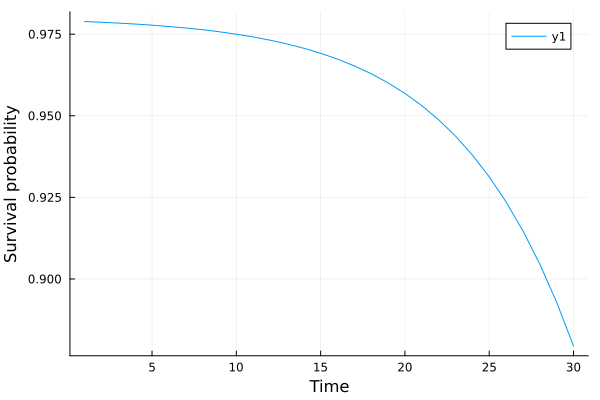

In [39]:
n⁻ = 1
n = 2

plot(1:1:30, x->SurvivalProbability(x, x+1, θ, [0.0,n⁻,0.0], [0.0,n,0.0], S0), xlabel="Time", ylabel="Survival probability")

Intuitively I would think that should be decreasing in time.
I mean the probability to survive given that 1 metastasis occurs, should then just depend on the time and should decrease in it, since the death rate grows in time. 

I guess this different behaviour comes from multiplying with the probability to get a metastasis at a timepoint, when integrating over timepoints at which a metastasis can occur.

In [40]:
metTest(t) = lambdaN(t, beta, m_basal, m_size, S0)*exp(-LambdaN(t, t+1, beta, m_basal, m_size, S0))

metTest (generic function with 1 method)

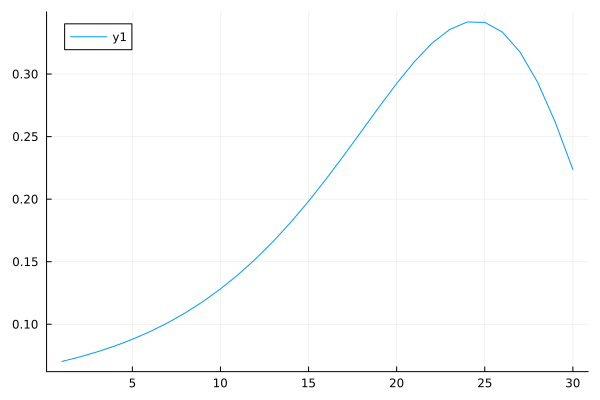

In [41]:
plot(1:30, x -> metTest(x))

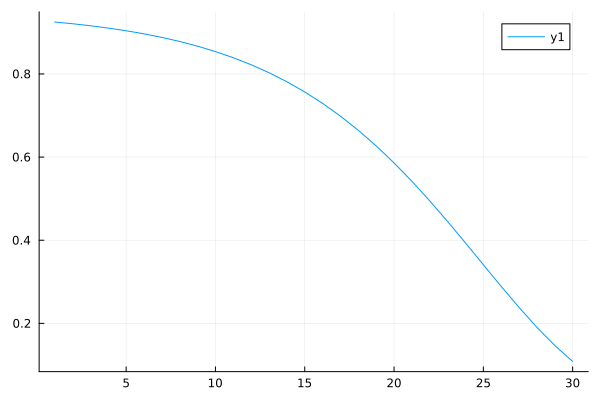

In [42]:
plot(1:30, x -> exp(-LambdaN(x, x+1, beta, m_basal, m_size, S0)))

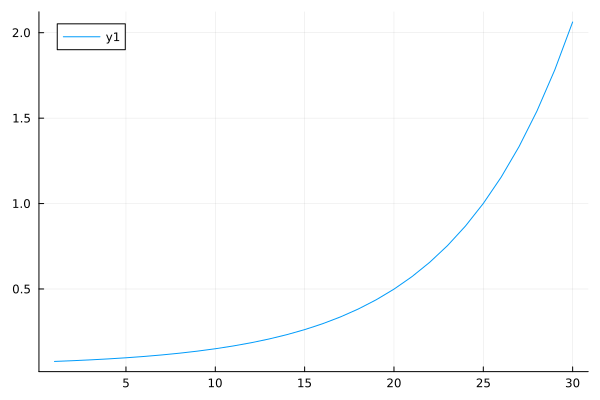

In [43]:
plot(1:30, x -> lambdaN(x, beta, m_basal, m_size, S0))

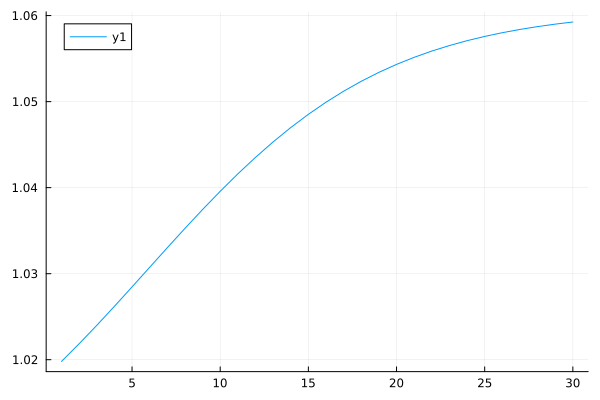

In [44]:
plot(1:30, x -> lambdaN(x-0.1, beta, m_basal, m_size, S0)/LambdaN(x-1, x, beta, m_basal, m_size, S0))

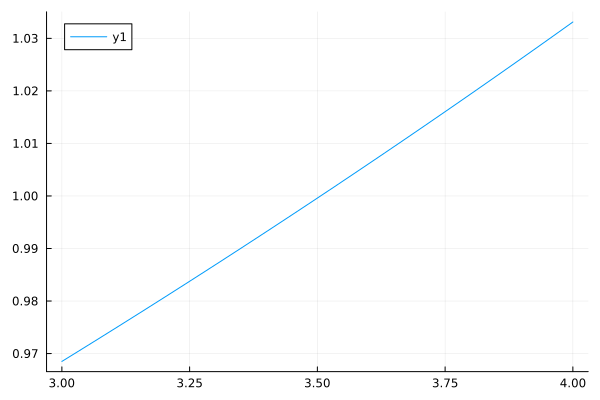

In [45]:
plot(3:0.01:4, x -> lambdaN(x, beta, m_basal, m_size, S0)/LambdaN(3, 4, beta, m_basal, m_size, S0))

And yes that term highly dominates the rest.


Do we really need to multiply with that term? I would say yes due to the law of toal probability one gets